# Legge dei punti coniugati

I dati sono presi da un'esperienza di laboratorio per la verifica della legge dei punti coniugati in ottica.

La legge è la seguente:

$\displaystyle \frac{1}{p} + \frac{1}{q} = \frac{1}{f}$

Nell'esperienza vengono misurati diversi valori di $p$ ed i corrispondenti $q$. Si calcolano quindi gli inversi e si propagani i corrispondenti errori.

Si eseque quindi una regressione lieare sulle variabili $x=1/p$ e $y=1/q$.

La presenza di errori, sia nella misura di $p$ (quindi di $x$) che di $q$ (quindi di $y$), non è in genere contemplata nelle procedure di regressione lineare.

Tuttavia, si può propagare l'errore su $x$ in base alla funzione di *fit* ed ottenere un contributo ulteriore all'errore su $y$. Il *fit* su può quindi iterare per ottenere una nuova stima, più accurata, con i suoi errori. La procedura si può iterare fino ad ottenere un valore stabile dei parametri del fit.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('data/lab_ottica_punti_coniugati.csv')

In [3]:
df

,p,q,dp,dq,Q,P,1/f,dQ,dP
0,32.0,57.5,0.5,0.5,0.017391,0.031250,0.048641,0.000151,0.000488
1,42.0,38.5,0.5,0.5,0.025974,0.023810,0.049784,0.000337,0.000283
2,52.5,33.0,0.5,0.5,0.030303,0.019048,0.049351,0.000459,0.000181
3,62.5,29.5,0.5,0.5,0.033898,0.016000,0.049898,0.000575,0.000128
4,71.5,28.0,0.5,0.5,0.035714,0.013986,0.049700,0.000638,0.000098
5,87.0,25.5,0.5,0.5,0.039216,0.011494,0.050710,0.000769,0.000066
6,95.0,25.0,0.5,0.5,0.040000,0.010526,0.050526,0.000800,0.000055
7,105.0,24.5,0.5,0.5,0.040816,0.009524,0.050340,0.000833,0.000045
8,119.0,23.5,0.5,0.5,0.042553,0.008403,0.050957,0.000905,0.000035
9,144.5,22.5,0.5,0.5,0.044444,0.006920,0.051365,0.000988,0.000024


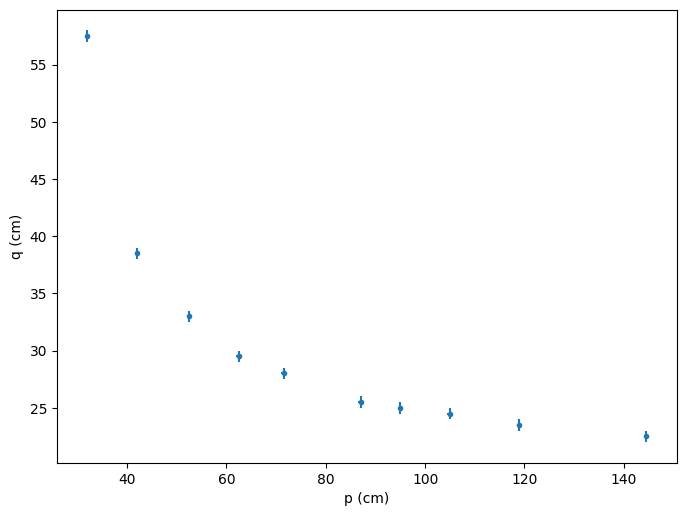

In [4]:
fig, ax = plt.subplots(figsize=(8, 6), dpi=100)
ax.errorbar(df.p, df.q, xerr=df.dp, yerr=df.dq, marker='o', markersize=3, linestyle='')
ax.set_xlabel('p (cm)')
ax.set_ylabel('q (cm)')
fig.show()

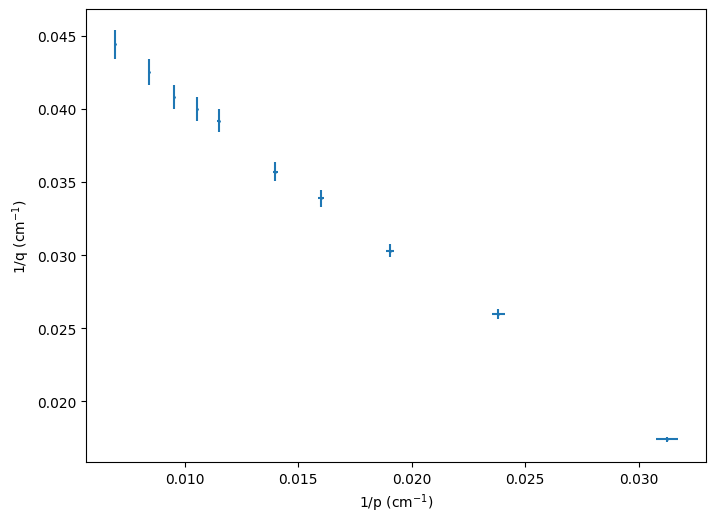

In [5]:
fig, ax = plt.subplots(figsize=(8, 6), dpi=100)
ax.errorbar(df.P, df.Q, xerr=df.dP, yerr=df.dQ, marker='o', markersize=1, linestyle='')
ax.set_xlabel('1/p (cm$^{-1}$)')
ax.set_ylabel('1/q (cm$^{-1}$)')
fig.show()

In [6]:
from scipy import stats
import math
import numpy as np

In [7]:
x, y = np.array(df.P.values), np.array(df.Q.values)
n_points = len(x)
err = np.array(df.dQ.values)
err2 = err**2
w = 1/err2
w /= w.sum()
x_mean = np.average(x, weights=w)
y_mean = np.average(y, weights=w)
dx = x - x_mean; dy = y - y_mean
dxdy = dx*dy*w; dx2 = dx*dx*w
dxdy_mean = dxdy.sum()
dx2_mean = dx2.sum()
b_fit = dxdy_mean/dx2_mean
a_fit = y_mean - b_fit*x_mean
def fit_line(x):
    return a_fit + x*b_fit

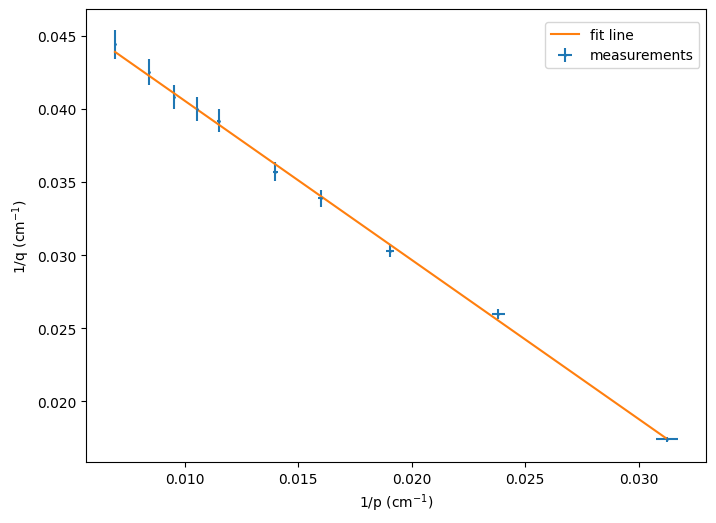

In [8]:
fig, ax = plt.subplots(figsize=(8, 6), dpi=100)
ax.errorbar(df.P, df.Q, xerr=df.dP, yerr=df.dQ, marker='o', markersize=1, linestyle='', label='measurements')
ax.plot(df.P, fit_line(df.P), label='fit line')
ax.set_xlabel('1/p ($\mathrm{cm}^{-1}$)')
ax.set_ylabel('1/q ($\mathrm{cm}^{-1}$)')
fig.legend(bbox_to_anchor=(0.9, 0.87))
fig.show()

In [9]:
y_fit = a_fit + b_fit*x
res = y - y_fit
res2 = res**2
res2_mean = np.average(res2, weights=w)
x2_mean = np.average(x**2, weights=w)
chi_2 = (res2/err2).sum()
ndof = n_points-2
var_b = res2_mean/dx2_mean/(n_points-2)
var_a = var_b*x2_mean
cov_ab = -var_b*x_mean
err_b = math.sqrt(var_b)
err_a = math.sqrt(var_a)
print('b = {:.5f} ± {:.5f}'.format(b_fit, err_b))
print('a = {:.5f} ± {:.5f}'.format(a_fit, err_a))
print('cov(a,b) = {:.8f}'.format(cov_ab))
print('chi^2 = ', chi_2, "/", ndof, "ndof")
print('p = ', 1 - stats.chi2.cdf(chi_2, ndof))

b = -1.08895 ± 0.01101
a = 0.05145 ± 0.00030
cov(a,b) = -0.00000316
chi^2 =  3.8862087018409888 / 8 ndof
p =  0.8672413313302776


## Propagazione degli errori su $x$

Un modo per propagare gli errori su $x$ è di stimare, una volta ottenuto il fit, l'effetto su $y$, e sommare questo contributo all'errore su $y$:

$\displaystyle \delta y^\prime = \left|\frac{\mathrm{d}}{\mathrm{d}x}(a+bx)\right|\delta x = \left|b\right|\delta x$

$\displaystyle \delta y^{\mathrm{tot}} = \sqrt{\delta y^2 + b^2\delta x^2}$

Si può quindi rifare il fit, ed eventualmente procedere iterativamente fino che la procedura non converge.

In [10]:
err = np.sqrt(np.array(df.dQ.values)**2+(b_fit*np.array(df.dP.values))**2)

In [11]:
err2 = err**2
w = 1/err2
w /= w.sum()
x_mean = np.average(x, weights=w)
y_mean = np.average(y, weights=w)
dx = x - x_mean; dy = y - y_mean
dxdy = dx*dy*w; dx2 = dx*dx*w
dxdy_mean = dxdy.sum()
dx2_mean = dx2.sum()
b_fit = dxdy_mean/dx2_mean
a_fit = y_mean - b_fit*x_mean
y_fit = a_fit + b_fit*x
res = y - y_fit
res2 = res**2
res2_mean = np.average(res2, weights=w)
x2_mean = np.average(x**2, weights=w)
chi_2 = (res2/err2).sum()
ndof = n_points-2
var_b = res2_mean/dx2_mean/(n_points-2)
var_a = var_b*x2_mean
cov_ab = -var_b*x_mean
err_b = math.sqrt(var_b)
err_a = math.sqrt(var_a)
print('b = {:.4f} ± {:.5f}'.format(b_fit, err_b))
print('a = {:.4f} ± {:.5f}'.format(a_fit, err_a))
print('cov(a,b) = {:.8f}'.format(cov_ab))
print('chi^2 = ', chi_2, "/", ndof, "ndof")
print('p = ', 1 - stats.chi2.cdf(chi_2, ndof))

b = -1.0842 ± 0.01666
a = 0.0514 ± 0.00033
cov(a,b) = -0.00000502
chi^2 =  2.862351161591656 / 8 ndof
p =  0.9426963613407063


 È possibile iterare la procedura fino a che la stima converga ad un valore stabile.
 In questo esempio, la modifica dovuta agli errori sulle misure $x_i$ è abbastanza piccola.